Project 2
<br>
Written by **Naga Satish Reddy Dwarampudi (40104630), Namita Faujdar(40105179)** 
<br>
For COMP 6721 **Section FI - Fall 2019**

In [23]:
import pandas as pd
import numpy as np
import nltk
import nltk.stem
import nltk.tokenize
import math
import copy
import sklearn.metrics
import matplotlib.pyplot as plt

In [24]:
def get_accuracy_score(data_model, post_type_lists):
    accuracy_score = sklearn.metrics.accuracy_score(data_model[7], data_model[2])
    print(accuracy_score)
    print(len(data_model[data_model[2] == data_model[7]]))
    p_r_f = sklearn.metrics.classification_report(data_model[7], data_model[2])
    confusion = sklearn.metrics.confusion_matrix(data_model[7], data_model[2], labels=post_type_lists)
    confusion_matrix = pd.DataFrame(confusion, index=post_type_lists, columns=post_type_lists)
    display(confusion_matrix)
    print(p_r_f)
    return accuracy_score

In [25]:
def create_model_file(model_file_name, vocabulory_words, post_contents_map, post_type_list, smoothing_value):
    print("create model")
    if model_file_name is not None:
        model_file = open(model_file_name, 'w+', encoding='utf-8')
#     model_data_frame = pd.DataFrame()
    data_lists = []
    frequency_post_type={}
    lengths_of_data = {}
    for post_type in post_type_list:
        frequency_post_type[post_type] = nltk.FreqDist(post_contents_map[post_type])
        lengths_of_data[post_type] = len(post_contents_map[post_type])
    for index, word in enumerate(vocabulory_words):
#         data_to_insert = {0: [index+1], 1: [word]}
        frequencies = "%d  %s"%(index+1, word)
        for post_type in post_type_list:
            freq_dist = frequency_post_type[post_type]   
            frquency_count = freq_dist[word]
            conditional_prob_smoothing = (frquency_count + smoothing_value)/(lengths_of_data[post_type] + (len(vocabulory_words) * smoothing_value))
#             data_to_insert[len(data_to_insert)] = frquency_count
#             data_to_insert[len(data_to_insert)] = conditional_prob_smoothing
            frequencies = "%s  %d  %.10f"%(frequencies, frquency_count, conditional_prob_smoothing)
        sentence_to_write_in_file = "%s\n"%(frequencies)
        if model_file_name is not None:
            model_file.write(sentence_to_write_in_file)
#         model_data_frame = model_data_frame.append(pd.DataFrame(data_to_insert))
        data_lists.append(frequencies.split('  '))
    if model_file_name is not None:
        model_file.close()
    model_data_frame = pd.DataFrame(data_lists)
    return model_data_frame

In [26]:
def get_post_contents(posts_type_list):
    content_post_map = {}
    lemmatizer = nltk.stem.WordNetLemmatizer()
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    for post_type in posts_type_list:
        required_datas = eighteen_data[eighteen_data['Post Type'] == post_type]
        content = ' '.join(required_datas['Title'])
        content = content.lower()
        content = tokenizer.tokenize(content)
        content = list(dict.fromkeys(content))
        content = [lemmatizer.lemmatize(w, pos=nltk.corpus.wordnet.VERB) for w in content]
        content_post_map[post_type] = content
    return content_post_map

In [27]:
def getModelDatas(file_name_stored):
    return pd.read_csv(file_name_stored, sep="  ", engine='python', encoding='utf-8', header=None)

In [28]:
def get_probabilities_of_post_types(eighteen_data, post_type_lists, all_title_content):
    probabilities_of_posts = {}
    total_length = len(eighteen_data)
    for post_type in post_type_lists:
        length_of_post_type = len(eighteen_data['Post Type'] == post_type)
        probabilities_of_posts[post_type] = length_of_post_type/ total_length
    return probabilities_of_posts

In [29]:
def get_prob_value(post_type, post_type_lists):
    return -2*(len(post_type_lists) - post_type_lists.index(post_type)) + 1

In [30]:
def implement_naive_bayes_classifier(model_data_frame, out_file, test_data, post_type_lists):
    print("Implement and test Naive bayes classifier")
    print("Finding probabilities of post types")
    probability_of_post_types = get_probabilities_of_post_types(eighteen_data, post_type_lists, all_title_content)
    
    lemmatizer = nltk.stem.WordNetLemmatizer()
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    total_sentences = '\n'.join(test_data['Title'].str.lower())
    total_sentences = total_sentences.split('\n')
    total_sentences_list = []
    for sentence in total_sentences:
        content = tokenizer.tokenize(sentence)
        content = [lemmatizer.lemmatize(w, pos=nltk.corpus.wordnet.VERB) for w in content]
        total_sentences_list.append(content)
    test_data_title_df = pd.DataFrame(total_sentences_list)
    test_data_title_df = test_data_title_df.replace([None], 1)
    test_data_post_map = {}
    for post_type in post_type_lists:
        test_data_post_map[post_type] = copy.deepcopy(test_data_title_df)
    for post_type in post_type_lists:
        for column_index in test_data_post_map[post_type].columns:
            values = pd.merge(test_data_post_map[post_type], model_data_frame, how='left',left_on=[column_index], right_on=[model_data_frame.keys()[1]])
            test_data_post_map[post_type][column_index] = values[values.keys()[get_prob_value(post_type, post_type_lists)]]
    
    for post_type in post_type_lists:
        post_data = test_data_post_map[post_type]
        post_data = post_data.apply(pd.to_numeric, errors='coerce')
        test_data_post_map[post_type] = post_data.replace([np.nan], 1)
        
    print("Added the probabilities with post type")
    scores_data = np.zeros([len(test_data['Title']), len(post_type_lists)])
    for index, post_type in enumerate(post_type_lists):
        test_data_post_map[post_type] = probability_of_post_types[post_type] + np.sum(np.log10(test_data_post_map[post_type]), axis=1)
        scores_data[:, index] = test_data_post_map[post_type]
    
    best_scores = np.argmax(scores_data, axis=1).astype('str')
    for index, post_type in enumerate(post_type_lists):
        best_scores[best_scores == str(index)] = post_type
        
    print("Creating and write data to file")
    d = {0: range(1, len(test_data['Title'])+1), 1: test_data['Title']}
    data_for_file = pd.DataFrame(d)
    data_for_file[len(data_for_file.columns)] = best_scores
    for index in range(0, scores_data.shape[1]):
        data_for_file[len(data_for_file.columns)] = scores_data[:, index]
    data_for_file[len(data_for_file.columns)] = test_data['Post Type']
    data_for_file[len(data_for_file.columns)] = np.where(data_for_file[2] == data_for_file[len(data_for_file.columns)-1], "right", "wrong")
    if out_file is not None:
        np.savetxt(out_file, data_for_file, fmt='%s', encoding='utf-8', delimiter='  ')
    return data_for_file

In [31]:
def get_unique_words_from_title(input_data):
    print("Getting all the data")
    all_title_content = []
#     data = [lambda: all_title_content.extend(getLemmatizeDataByBigram(sent.lower())) for sent in input_data['Title']]
    for sent in input_data['Title']:
        
# #     all_title_content = ' '.join(input_data['Title'])
        sent = sent.lower()
        all_title_content.extend(getLemmatizeDataByBigram(sent))
#     print("check me",list(data[0:100]))
    all_title_content = data = list(dict.fromkeys(all_title_content))
    all_title_content.sort()
    return all_title_content

In [32]:
def getLemmatizeDataByBigram(sent):
    
    lemmatizer = nltk.stem.WordNetLemmatizer()
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    token_sent = tokenizer.tokenize(sent)
    
#     token_sent = nltk.word_tokenize(sent)
    tagged_sent = nltk.pos_tag(token_sent)
    parts_of_speech_map = {}
    for data in tagged_sent:
        parts_of_speech_map[data[0]] = data[1]

    word_tag_pairs = list(nltk.bigrams(token_sent))


    data = []
    for words in word_tag_pairs:
        if words[0] == ',' and words[1] == ',':
            continue
        elif parts_of_speech_map[words[0]].startswith('N') and  parts_of_speech_map[words[1]] != ',' and parts_of_speech_map[words[1]].startswith('N'):
            if len(data) > 1 and data[-1] == words[0]:
                data = data[:-1]
            isTaken = True
            data.append('%s %s'%(words[0], words[1]))
        else:
            if words[1] != ',':
                data.append(words[1])
            isTaken = False

    data = [lemmatizer.lemmatize(w, pos=nltk.corpus.wordnet.VERB) for w in data]
    return data

In [33]:
print("Reading the hn2018_2019.csv")
data = pd.read_csv('hn2018_2019.csv')
columns_to_drop = ['Unnamed: 0']
data.drop(columns_to_drop, inplace=True, axis = 1)
print("Seperating 2018 and 2019 data")
eighteen_data = data[(data['Created At'] >='2018-01-01 00:00:00') & (data['Created At'] <= '2018-12-31 23:59:59')]
nineteen_data = data[(data['Created At'] >='2019-01-01 00:00:00') & (data['Created At'] <= '2019-12-31 23:59:59')]
    
print("Getting types of posts available")
get_posts = set(data['Post Type'])
post_type_lists = list(get_posts)
post_contents_map = get_post_contents(list(get_posts))

all_title_content = get_unique_words_from_title(eighteen_data)
print("Writing vocabulory to file")
with open("vocabulory.txt", "w+", encoding='utf-8') as f:
    f.write('\n'.join(all_title_content))
    
model_data_frame = create_model_file('model-2018.txt', all_title_content, post_contents_map, post_type_lists, 0.5)
data_model = implement_naive_bayes_classifier(model_data_frame, "baseline-result.txt", nineteen_data, post_type_lists)
print("Testing Data 2019")
accuracy_score = get_accuracy_score(data_model, post_type_lists)
for post_type in post_type_lists:
    print(post_type, len(data_model[data_model[7] == post_type]), len(data_model[data_model[2] == post_type]))

print("Training data 2018")
train_data_model = implement_naive_bayes_classifier(model_data_frame, None, eighteen_data, post_type_lists)
get_accuracy_score(train_data_model, post_type_lists)
print("Task 1 Finished execution")

Reading the hn2018_2019.csv
Seperating 2018 and 2019 data
Getting types of posts available
Getting all the data
Writing vocabulory to file
create model
Implement and test Naive bayes classifier
Finding probabilities of post types
Added the probabilities with post type
Creating and write data to file
Testing Data 2019
0.17461647779032904
23960


ask_hn  story  poll  show_hn
ask_hn     4453     25     0      976
story     76830  17694   127    32201
poll          3      0     0        3
show_hn    2998     92     0     1813

              precision    recall  f1-score   support

      ask_hn       0.05      0.82      0.10      5454
        poll       0.00      0.00      0.00         6
     show_hn       0.05      0.37      0.09      4903
       story       0.99      0.14      0.24    126852

    accuracy                           0.17    137215
   macro avg       0.27      0.33      0.11    137215
weighted avg       0.92      0.17      0.23    137215

ask_hn 5454 84284
story 126852 17811
poll 6 127
show_hn 4903 34993
Training data 2018
Implement and test Naive bayes classifier
Finding probabilities of post types
Added the probabilities with post type
Creating and write data to file
0.19763449478484083
54741


ask_hn  story  poll  show_hn
ask_hn    11123      3     0     1383
story    152188  36736   132    65166
poll          8      0     3       14
show_hn    3326     20     0     6879

              precision    recall  f1-score   support

      ask_hn       0.07      0.89      0.12     12509
        poll       0.02      0.12      0.04        25
     show_hn       0.09      0.67      0.16     10225
       story       1.00      0.14      0.25    254222

    accuracy                           0.20    276981
   macro avg       0.30      0.46      0.14    276981
weighted avg       0.92      0.20      0.24    276981

Task 1 Finished execution


In [34]:
# from nltk.corpus import stopwords
print('Stop words task started')
# stop_words_list = set(stopwords.words('english'))
# print(stop_words_list)
file_data = open("Stopwords.txt").read()
stop_words_list = file_data.split("\n")
vocobulary_with_out_stop_words = [w for w in all_title_content if w not in stop_words_list]
model_data_frame = create_model_file('stopword-model-2018.txt', vocobulary_with_out_stop_words, post_contents_map, post_type_lists, 0.5)
data_model = implement_naive_bayes_classifier(model_data_frame, "stopword-result.txt", nineteen_data, post_type_lists)
accuracy_score = get_accuracy_score(data_model, post_type_lists)
train_data_model = implement_naive_bayes_classifier(model_data_frame, None, eighteen_data, post_type_lists)
get_accuracy_score(train_data_model, post_type_lists)
print('Stop words Task Finished')

Stop words task started
create model
Implement and test Naive bayes classifier
Finding probabilities of post types
Added the probabilities with post type
Creating and write data to file
0.3021244033086762
41456


ask_hn  story  poll  show_hn
ask_hn     4185    158     0     1111
story     62774  35443    46    28589
poll          3      1     0        2
show_hn    2861    214     0     1828

              precision    recall  f1-score   support

      ask_hn       0.06      0.77      0.11      5454
        poll       0.00      0.00      0.00         6
     show_hn       0.06      0.37      0.10      4903
       story       0.99      0.28      0.44    126852

    accuracy                           0.30    137215
   macro avg       0.28      0.35      0.16    137215
weighted avg       0.92      0.30      0.41    137215

Implement and test Naive bayes classifier
Finding probabilities of post types
Added the probabilities with post type
Creating and write data to file
0.3295532906589261
91280


ask_hn  story  poll  show_hn
ask_hn    10793     46     0     1670
story    123267  73465    79    57411
poll          4      3     7       11
show_hn    3141     69     0     7015

              precision    recall  f1-score   support

      ask_hn       0.08      0.86      0.14     12509
        poll       0.08      0.28      0.13        25
     show_hn       0.11      0.69      0.18     10225
       story       1.00      0.29      0.45    254222

    accuracy                           0.33    276981
   macro avg       0.32      0.53      0.23    276981
weighted avg       0.92      0.33      0.42    276981

Stop words Task Finished


In [35]:
print('Word Length Filtering ')
vocobulary_with_length_filter = [w for w in all_title_content if len(w) >= 2 and len(w)<=9]
model_data_frame = create_model_file('wordlength-model-2018.txt', vocobulary_with_length_filter, post_contents_map, post_type_lists, 0.5)
data_model = implement_naive_bayes_classifier(model_data_frame, "wordlength-result.txt", nineteen_data, post_type_lists)
accuracy_score = get_accuracy_score(data_model, post_type_lists)
train_data_model = implement_naive_bayes_classifier(model_data_frame, None, eighteen_data, post_type_lists)
get_accuracy_score(train_data_model, post_type_lists)
print('Word Length Filtering Finished')

Word Length Filtering 
create model
Implement and test Naive bayes classifier
Finding probabilities of post types
Added the probabilities with post type
Creating and write data to file
0.048952374011587654
6717


ask_hn  story  poll  show_hn
ask_hn     5001      0     2      451
story     97794    517  1573    26968
poll          3      0     1        2
show_hn    3704      0     1     1198

              precision    recall  f1-score   support

      ask_hn       0.05      0.92      0.09      5454
        poll       0.00      0.17      0.00         6
     show_hn       0.04      0.24      0.07      4903
       story       1.00      0.00      0.01    126852

    accuracy                           0.05    137215
   macro avg       0.27      0.33      0.04    137215
weighted avg       0.93      0.05      0.01    137215

Implement and test Naive bayes classifier
Finding probabilities of post types
Added the probabilities with post type
Creating and write data to file
0.06441958112650326
17843


ask_hn  story  poll  show_hn
ask_hn    11993      0     0      516
story    195574    948  3171    54529
poll          4      0    17        4
show_hn    5340      0     0     4885

              precision    recall  f1-score   support

      ask_hn       0.06      0.96      0.11     12509
        poll       0.01      0.68      0.01        25
     show_hn       0.08      0.48      0.14     10225
       story       1.00      0.00      0.01    254222

    accuracy                           0.06    276981
   macro avg       0.29      0.53      0.07    276981
weighted avg       0.92      0.06      0.02    276981

Word Length Filtering Finished


Infrequent Word Filtering
create model
Implement and test Naive bayes classifier
Finding probabilities of post types
Added the probabilities with post type
Creating and write data to file
27410 214895
0.043406333126844734
5956


ask_hn  story  poll  show_hn
ask_hn     5148      0    90      216
story    101183     40  8616    17013
poll          3      0     3        0
show_hn    4115      0    23      765

              precision    recall  f1-score   support

      ask_hn       0.05      0.94      0.09      5454
        poll       0.00      0.50      0.00         6
     show_hn       0.04      0.16      0.07      4903
       story       1.00      0.00      0.00    126852

    accuracy                           0.04    137215
   macro avg       0.27      0.40      0.04    137215
weighted avg       0.93      0.04      0.01    137215

create model
Implement and test Naive bayes classifier
Finding probabilities of post types
Added the probabilities with post type
Creating and write data to file
14796 214895
0.030018583974055314
4119


ask_hn  story   poll  show_hn
ask_hn     3835      0   1556       63
story     77273      1  42115     7463
poll          0      0      6        0
show_hn    3978      0    648      277

              precision    recall  f1-score   support

      ask_hn       0.05      0.70      0.08      5454
        poll       0.00      1.00      0.00         6
     show_hn       0.04      0.06      0.04      4903
       story       1.00      0.00      0.00    126852

    accuracy                           0.03    137215
   macro avg       0.27      0.44      0.03    137215
weighted avg       0.93      0.03      0.00    137215

create model
Implement and test Naive bayes classifier
Finding probabilities of post types
Added the probabilities with post type
Creating and write data to file
10522 214895
0.012673541522428305
1739


D:\Programs Files\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ask_hn  story   poll  show_hn
ask_hn     1657      0   3782       15
story     46405      0  77391     3056
poll          0      0      6        0
show_hn    2516      0   2311       76

              precision    recall  f1-score   support

      ask_hn       0.03      0.30      0.06      5454
        poll       0.00      1.00      0.00         6
     show_hn       0.02      0.02      0.02      4903
       story       0.00      0.00      0.00    126852

    accuracy                           0.01    137215
   macro avg       0.01      0.33      0.02    137215
weighted avg       0.00      0.01      0.00    137215

create model
Implement and test Naive bayes classifier
Finding probabilities of post types
Added the probabilities with post type
Creating and write data to file
8453 214895
0.004562183434755675
626


ask_hn  story    poll  show_hn
ask_hn      597      0    4855        2
story     24196      0  101051     1605
poll          0      0       6        0
show_hn    1197      0    3683       23

              precision    recall  f1-score   support

      ask_hn       0.02      0.11      0.04      5454
        poll       0.00      1.00      0.00         6
     show_hn       0.01      0.00      0.01      4903
       story       0.00      0.00      0.00    126852

    accuracy                           0.00    137215
   macro avg       0.01      0.28      0.01    137215
weighted avg       0.00      0.00      0.00    137215

create model
Implement and test Naive bayes classifier
Finding probabilities of post types
Added the probabilities with post type
Creating and write data to file
7170 214895
0.0014138395947964873
194


ask_hn  story    poll  show_hn
ask_hn      185      0    5269        0
story     14834      0  111221      797
poll          0      0       6        0
show_hn     565      0    4335        3

              precision    recall  f1-score   support

      ask_hn       0.01      0.03      0.02      5454
        poll       0.00      1.00      0.00         6
     show_hn       0.00      0.00      0.00      4903
       story       0.00      0.00      0.00    126852

    accuracy                           0.00    137215
   macro avg       0.00      0.26      0.00    137215
weighted avg       0.00      0.00      0.00    137215

Infrequent Word Finished


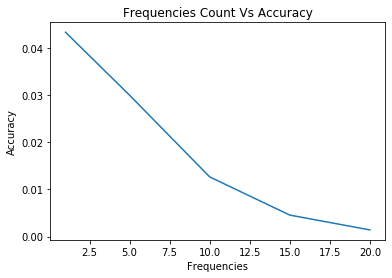

In [36]:
print("Infrequent Word Filtering")
frequency_count_values = [1,5,10,15,20]
vocabulary_words = ' '.join(eighteen_data['Title'])
vocabulary_words = vocabulary_words.lower()
lemmatizer = nltk.stem.WordNetLemmatizer()
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
words_tokens = tokenizer.tokenize(vocabulary_words)
vocabulary_words = [lemmatizer.lemmatize(w) for w in words_tokens]
vocabulary_words = list(vocabulary_words)
vocabulary_words.sort()
freq_dist = nltk.FreqDist(vocabulary_words)
vocabulory_words_after_freq = copy.deepcopy(all_title_content)
accuracy_list = []
for frequency_value in frequency_count_values:
    vocabulory_words_after_freq = [word for word in vocabulory_words_after_freq if freq_dist[word] > frequency_value]
    model_data_frame = create_model_file(None, vocabulory_words_after_freq, post_contents_map, post_type_lists, 0.5)
    data_model = implement_naive_bayes_classifier(model_data_frame, None, nineteen_data, post_type_lists)
    print(len(vocabulory_words_after_freq), len(all_title_content))
    accuracy_score = get_accuracy_score(data_model, post_type_lists)
    accuracy_list.append(accuracy_score)
plt.plot(frequency_count_values, accuracy_list)
plt.title("Frequencies Count Vs Accuracy")
plt.xlabel("Frequencies")
plt.ylabel("Accuracy")
#     print(frequency_value)
print("Infrequent Word Finished")

Most Frequent words Removing
create model
Implement and test Naive bayes classifier
Finding probabilities of post types
Added the probabilities with post type
Creating and write data to file
205795 214895
0.3096527347593193
42489


ask_hn  story  poll  show_hn
ask_hn     4648    564    94      148
story     82794  37300  1266     5492
poll          5      1     0        0
show_hn    3556    757    49      541

              precision    recall  f1-score   support

      ask_hn       0.05      0.85      0.10      5454
        poll       0.00      0.00      0.00         6
     show_hn       0.09      0.11      0.10      4903
       story       0.97      0.29      0.45    126852

    accuracy                           0.31    137215
   macro avg       0.28      0.31      0.16    137215
weighted avg       0.90      0.31      0.42    137215

create model
Implement and test Naive bayes classifier
Finding probabilities of post types
Added the probabilities with post type
Creating and write data to file
197370 214895
0.1916262799256641
26294


ask_hn  story  poll  show_hn
ask_hn     4945    308   111       90
story    100496  21021  1682     3653
poll          5      1     0        0
show_hn    4081    442    52      328

              precision    recall  f1-score   support

      ask_hn       0.05      0.91      0.09      5454
        poll       0.00      0.00      0.00         6
     show_hn       0.08      0.07      0.07      4903
       story       0.97      0.17      0.28    126852

    accuracy                           0.19    137215
   macro avg       0.27      0.28      0.11    137215
weighted avg       0.90      0.19      0.27    137215

create model
Implement and test Naive bayes classifier
Finding probabilities of post types
Added the probabilities with post type
Creating and write data to file
190248 214895
0.14704660569179753
20177


ask_hn  story  poll  show_hn
ask_hn     5069    206   115       64
story    107001  14864  1726     3261
poll          5      1     0        0
show_hn    4326    275    58      244

              precision    recall  f1-score   support

      ask_hn       0.04      0.93      0.08      5454
        poll       0.00      0.00      0.00         6
     show_hn       0.07      0.05      0.06      4903
       story       0.97      0.12      0.21    126852

    accuracy                           0.15    137215
   macro avg       0.27      0.27      0.09    137215
weighted avg       0.90      0.15      0.20    137215

create model
Implement and test Naive bayes classifier
Finding probabilities of post types
Added the probabilities with post type
Creating and write data to file
184123 214895
0.12965054840943047
17790


ask_hn  story  poll  show_hn
ask_hn     5107    171   115       61
story    109469  12486  1737     3160
poll          5      1     0        0
show_hn    4440    206    60      197

              precision    recall  f1-score   support

      ask_hn       0.04      0.94      0.08      5454
        poll       0.00      0.00      0.00         6
     show_hn       0.06      0.04      0.05      4903
       story       0.97      0.10      0.18    126852

    accuracy                           0.13    137215
   macro avg       0.27      0.27      0.08    137215
weighted avg       0.90      0.13      0.17    137215

create model
Implement and test Naive bayes classifier
Finding probabilities of post types
Added the probabilities with post type
Creating and write data to file
179639 214895
0.12099989068250555
16603


ask_hn  story  poll  show_hn
ask_hn     5132    145   115       62
story    110711  11295  1739     3107
poll          5      1     0        0
show_hn    4493    174    60      176

              precision    recall  f1-score   support

      ask_hn       0.04      0.94      0.08      5454
        poll       0.00      0.00      0.00         6
     show_hn       0.05      0.04      0.04      4903
       story       0.97      0.09      0.16    126852

    accuracy                           0.12    137215
   macro avg       0.27      0.27      0.07    137215
weighted avg       0.90      0.12      0.16    137215

Most Frequent words Removing Finished


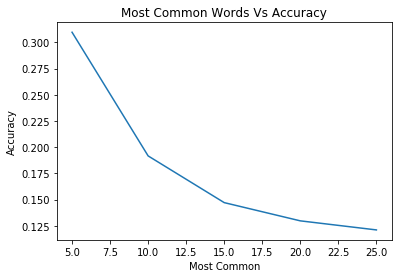

In [37]:
print("Most Frequent words Removing")
accuracy_list = []
frequency_percentage = [5, 10, 15, 20, 25]
vocabulory_words_uniques = copy.deepcopy(all_title_content)

accuracy_list = []
for frequency_value in frequency_percentage:
    frequency_words = frequency_value / 100 * len(all_title_content)
    most_frequent_words = freq_dist.most_common(int(frequency_words))
    words_to_remove = [word[0] for word in most_frequent_words]
    vocabulory_words = [word for word in vocabulory_words_uniques if word not in words_to_remove]
    model_data_frame = create_model_file(None, vocabulory_words, post_contents_map, post_type_lists, 0.5)
    data_model = implement_naive_bayes_classifier(model_data_frame, None, nineteen_data, post_type_lists)
    print(len(vocabulory_words), len(all_title_content))
    accuracy_score = get_accuracy_score(data_model, post_type_lists)
    accuracy_list.append(accuracy_score)
plt.plot(frequency_percentage, accuracy_list)
plt.title("Most Common Words Vs Accuracy")
plt.xlabel("Most Common")
plt.ylabel("Accuracy")
print("Most Frequent words Removing Finished")

Smoothing value 
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
create model
Implement and test Naive bayes classifier
Finding probabilities of post types
Added the probabilities with post type


D:\Programs Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log10


Creating and write data to file
0.5054257916408555
69352


ask_hn  story  poll  show_hn
ask_hn     4322    836     0      296
story     50585  63949   120    12198
poll          4      1     0        1
show_hn    2721   1101     0     1081

              precision    recall  f1-score   support

      ask_hn       0.07      0.79      0.14      5454
        poll       0.00      0.00      0.00         6
     show_hn       0.08      0.22      0.12      4903
       story       0.97      0.50      0.66    126852

    accuracy                           0.51    137215
   macro avg       0.28      0.38      0.23    137215
weighted avg       0.90      0.51      0.62    137215

create model
Implement and test Naive bayes classifier
Finding probabilities of post types
Added the probabilities with post type
Creating and write data to file
0.08687096891739242
11920


ask_hn  story  poll  show_hn
ask_hn     4943      2     0      509
story     93239   5408   360    27845
poll          3      0     0        3
show_hn    3332      2     0     1569

              precision    recall  f1-score   support

      ask_hn       0.05      0.91      0.09      5454
        poll       0.00      0.00      0.00         6
     show_hn       0.05      0.32      0.09      4903
       story       1.00      0.04      0.08    126852

    accuracy                           0.09    137215
   macro avg       0.28      0.32      0.07    137215
weighted avg       0.93      0.09      0.08    137215

create model
Implement and test Naive bayes classifier
Finding probabilities of post types
Added the probabilities with post type
Creating and write data to file
0.10554968480122436
14483


ask_hn  story  poll  show_hn
ask_hn     4748      5     0      701
story     87363   8027   247    31215
poll          3      0     0        3
show_hn    3178     17     0     1708

              precision    recall  f1-score   support

      ask_hn       0.05      0.87      0.09      5454
        poll       0.00      0.00      0.00         6
     show_hn       0.05      0.35      0.09      4903
       story       1.00      0.06      0.12    126852

    accuracy                           0.11    137215
   macro avg       0.27      0.32      0.08    137215
weighted avg       0.93      0.11      0.12    137215

create model
Implement and test Naive bayes classifier
Finding probabilities of post types
Added the probabilities with post type
Creating and write data to file
0.12786502933352767
17545


ask_hn  story  poll  show_hn
ask_hn     4643      9     0      802
story     83641  11127   233    31851
poll          3      0     0        3
show_hn    3096     32     0     1775

              precision    recall  f1-score   support

      ask_hn       0.05      0.85      0.10      5454
        poll       0.00      0.00      0.00         6
     show_hn       0.05      0.36      0.09      4903
       story       1.00      0.09      0.16    126852

    accuracy                           0.13    137215
   macro avg       0.27      0.33      0.09    137215
weighted avg       0.92      0.13      0.16    137215

create model
Implement and test Naive bayes classifier
Finding probabilities of post types
Added the probabilities with post type
Creating and write data to file
0.15025325219545968
20617


ask_hn  story  poll  show_hn
ask_hn     4549     15     0      890
story     80165  14256   135    32296
poll          3      0     0        3
show_hn    3037     54     0     1812

              precision    recall  f1-score   support

      ask_hn       0.05      0.83      0.10      5454
        poll       0.00      0.00      0.00         6
     show_hn       0.05      0.37      0.09      4903
       story       1.00      0.11      0.20    126852

    accuracy                           0.15    137215
   macro avg       0.27      0.33      0.10    137215
weighted avg       0.92      0.15      0.19    137215

create model
Implement and test Naive bayes classifier
Finding probabilities of post types
Added the probabilities with post type
Creating and write data to file
0.17461647779032904
23960


ask_hn  story  poll  show_hn
ask_hn     4453     25     0      976
story     76830  17694   127    32201
poll          3      0     0        3
show_hn    2998     92     0     1813

              precision    recall  f1-score   support

      ask_hn       0.05      0.82      0.10      5454
        poll       0.00      0.00      0.00         6
     show_hn       0.05      0.37      0.09      4903
       story       0.99      0.14      0.24    126852

    accuracy                           0.17    137215
   macro avg       0.27      0.33      0.11    137215
weighted avg       0.92      0.17      0.23    137215

create model
Implement and test Naive bayes classifier
Finding probabilities of post types
Added the probabilities with post type
Creating and write data to file
0.19610100936486535
26908


ask_hn  story  poll  show_hn
ask_hn     4398     42     0     1014
story     74387  20726   127    31612
poll          3      0     0        3
show_hn    2970    149     0     1784

              precision    recall  f1-score   support

      ask_hn       0.05      0.81      0.10      5454
        poll       0.00      0.00      0.00         6
     show_hn       0.05      0.36      0.09      4903
       story       0.99      0.16      0.28    126852

    accuracy                           0.20    137215
   macro avg       0.27      0.33      0.12    137215
weighted avg       0.92      0.20      0.27    137215

create model
Implement and test Naive bayes classifier
Finding probabilities of post types
Added the probabilities with post type
Creating and write data to file
0.21687133330904057
29758


ask_hn  story  poll  show_hn
ask_hn     4331     62     0     1061
story     72069  23670   127    30986
poll          3      0     0        3
show_hn    2935    211     0     1757

              precision    recall  f1-score   support

      ask_hn       0.05      0.79      0.10      5454
        poll       0.00      0.00      0.00         6
     show_hn       0.05      0.36      0.09      4903
       story       0.99      0.19      0.31    126852

    accuracy                           0.22    137215
   macro avg       0.27      0.33      0.13    137215
weighted avg       0.92      0.22      0.30    137215

create model
Implement and test Naive bayes classifier
Finding probabilities of post types
Added the probabilities with post type
Creating and write data to file
0.23670152680100573
32479


ask_hn  story  poll  show_hn
ask_hn     4291     88     0     1075
story     69913  26450   126    30363
poll          3      0     0        3
show_hn    2890    275     0     1738

              precision    recall  f1-score   support

      ask_hn       0.06      0.79      0.10      5454
        poll       0.00      0.00      0.00         6
     show_hn       0.05      0.35      0.09      4903
       story       0.99      0.21      0.34    126852

    accuracy                           0.24    137215
   macro avg       0.27      0.34      0.13    137215
weighted avg       0.92      0.24      0.33    137215

create model
Implement and test Naive bayes classifier
Finding probabilities of post types
Added the probabilities with post type
Creating and write data to file
0.2558685274933499
35109


ask_hn  story  poll  show_hn
ask_hn     4247    121     0     1086
story     67933  29164   125    29630
poll          3      0     0        3
show_hn    2867    338     0     1698

              precision    recall  f1-score   support

      ask_hn       0.06      0.78      0.11      5454
        poll       0.00      0.00      0.00         6
     show_hn       0.05      0.35      0.09      4903
       story       0.98      0.23      0.37    126852

    accuracy                           0.26    137215
   macro avg       0.27      0.34      0.14    137215
weighted avg       0.91      0.26      0.35    137215

create model
Implement and test Naive bayes classifier
Finding probabilities of post types
Added the probabilities with post type
Creating and write data to file
0.2737164304194148
37558


ask_hn  story  poll  show_hn
ask_hn     4206    157     0     1091
story     66055  31700   125    28972
poll          3      1     0        2
show_hn    2817    434     0     1652

              precision    recall  f1-score   support

      ask_hn       0.06      0.77      0.11      5454
        poll       0.00      0.00      0.00         6
     show_hn       0.05      0.34      0.09      4903
       story       0.98      0.25      0.40    126852

    accuracy                           0.27    137215
   macro avg       0.27      0.34      0.15    137215
weighted avg       0.91      0.27      0.38    137215

Smoothing value finished


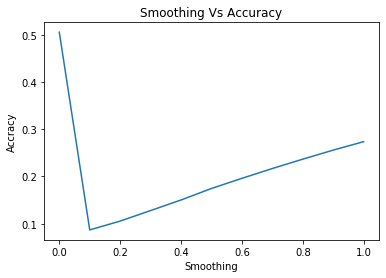

In [38]:
print("Smoothing value ")
smoothing_values_list = np.linspace(0.0, 1.0, 11)
print(smoothing_values_list)
accuracy_list = []
for smooth in smoothing_values_list:
    model_data_frame = create_model_file('model-2018.txt', all_title_content, post_contents_map, post_type_lists, smooth)
    data_model = implement_naive_bayes_classifier(model_data_frame, None, nineteen_data, post_type_lists)
    accuracy_score = get_accuracy_score(data_model, post_type_lists)
    accuracy_list.append(accuracy_score)
plt.plot(smoothing_values_list, accuracy_list)
plt.title("Smoothing Vs Accuracy")
plt.xlabel("Smoothing")
plt.ylabel("Accracy")
print("Smoothing value finished")